In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Navigate to your project folder (update the path to your dataset location)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import zipfile
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder

In [4]:
# Step 1: Unzip the dataset
zip_path = "/content/drive/MyDrive/cnn.zip"  # Path to the uploaded zip file
unzip_dir = "/content/project"  # Destination folder

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print(f"Unzipped dataset to: {unzip_dir}")


Unzipped dataset to: /content/project


In [5]:
# Install necessary libraries
!pip install keras tensorflow matplotlib


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import preprocess_input
# Data augmentation for training
train_datagen = ImageDataGenerator(
    zoom_range=0.5,
    shear_range=0.3,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

# Validation and test generators
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Paths to training, validation, and test datasets
train_dir = os.path.join(unzip_dir, 'cnn/train')
valid_dir = os.path.join(unzip_dir, 'cnn/valid')
test_dir = os.path.join(unzip_dir, 'cnn/test')

# Loading datasets
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(416,416),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    directory=valid_dir,
    target_size=(416,416),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(416,416),
    batch_size=32,
    class_mode='categorical'
)


Found 7324 images belonging to 6 classes.
Found 2095 images belonging to 6 classes.
Found 1045 images belonging to 6 classes.


In [10]:
# Load pre-trained VGG19 model without top layers
base_model = VGG19(input_shape=(416, 416, 3), include_top=False, weights='imagenet')

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
X = Flatten()(base_model.output)
X = Dense(units=len(train_generator.class_indices), activation='softmax')(X)

# Final model
model = Model(base_model.input, X)
model.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 416, 416, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 416, 416, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 416, 416, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 208, 208, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 208, 208, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 208, 208, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 104, 104, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 104, 104, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 104, 104, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 104, 104, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 104, 104, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 52, 52, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 52, 52, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 52, 52, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 52, 52, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 52, 52, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 26, 26, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 26, 26, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 26, 26, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 26, 26, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 26, 26, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,543,558 (78.37 MB)

 Trainable params: 519,174 (1.98 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [12]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
es = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, restore_best_weights=True)
mc = ModelCheckpoint(filepath='best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[es, mc]
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6700 - loss: 11.3316
Epoch 1: val_accuracy improved from -inf to 0.80962, saving model to best_model.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 435s 2s/step - accuracy: 0.6703 - loss: 11.3300 - val_accuracy: 0.8096 - val_loss: 12.6056
Epoch 2/10
  1/228 ━━━━━━━━━━━━━━━━━━━━ 1:57 517ms/step - accuracy: 0.7500 - loss: 13.2808

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.80962 to 0.93333, saving model to best_model.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.7500 - loss: 13.2808 - val_accuracy: 0.9333 - val_loss: 1.9715
Epoch 3/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8220 - loss: 8.8875
Epoch 3: val_accuracy did not improve from 0.93333
228/228 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step - accuracy: 0.8221 - loss: 8.8872 - val_accuracy: 0.8313 - val_loss: 13.2112
Epoch 4/10
  1/228 ━━━━━━━━━━━━━━━━━━━━ 1:58 521ms/step - accuracy: 0.9062 - loss: 4.3613
Epoch 4: val_accuracy did not improve from 0.93333
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9062 - loss: 4.3613 - val_accuracy: 0.8000 - val_loss: 13.6561
Epoch 5/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8518 - loss: 8.4238
Epoch 5: val_accuracy did not improve from 0.93333
228/228 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.8517 - loss: 8.4278 - val_accuracy: 0.8327 - val_loss: 15.6227
Epoch 5: early stoppi

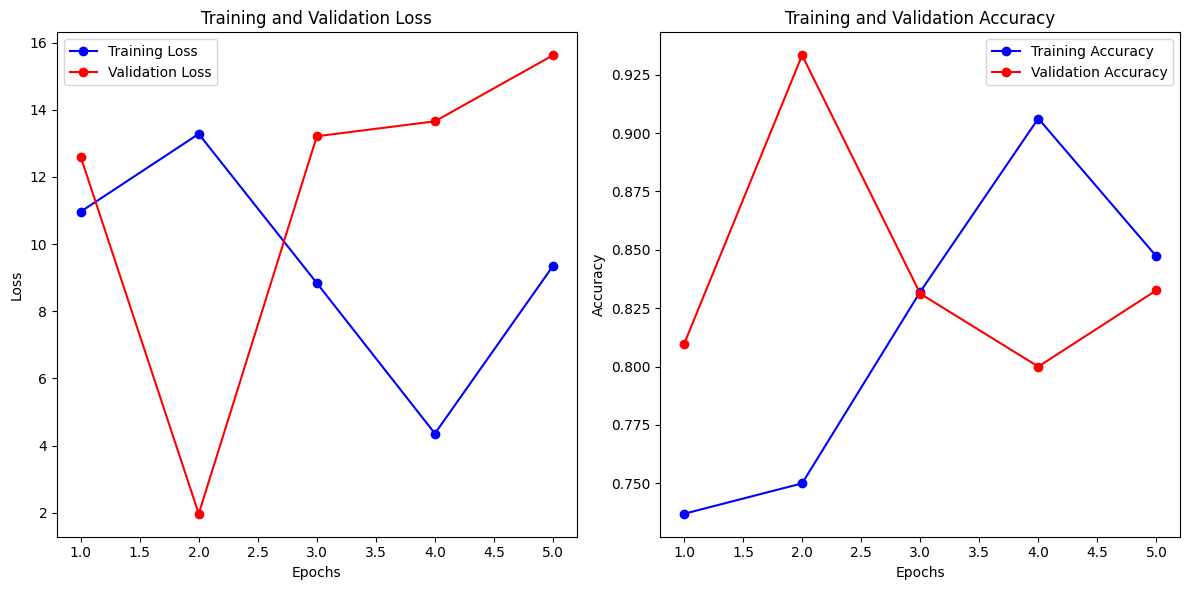

In [13]:
# Extract history data
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


33/33 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.7949 - loss: 10.9236
Test Accuracy: 80.38%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
# Save the model to a file
model.save('best_model.keras')  # Adjust the filename if needed


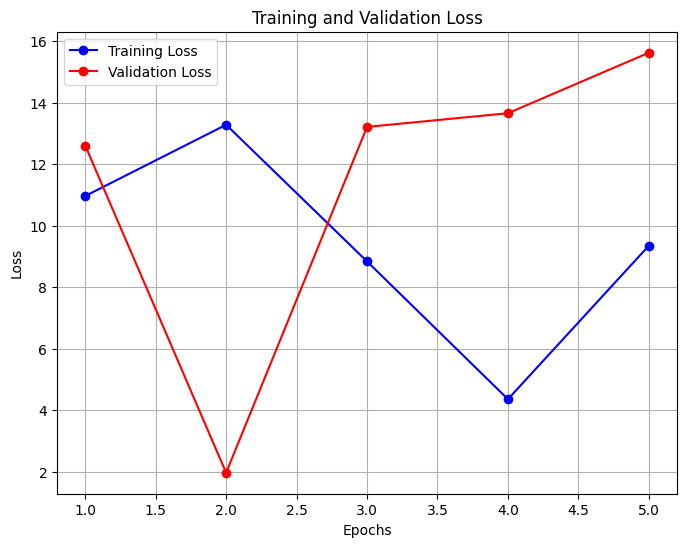

In [17]:
import matplotlib.pyplot as plt

# Extract data from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


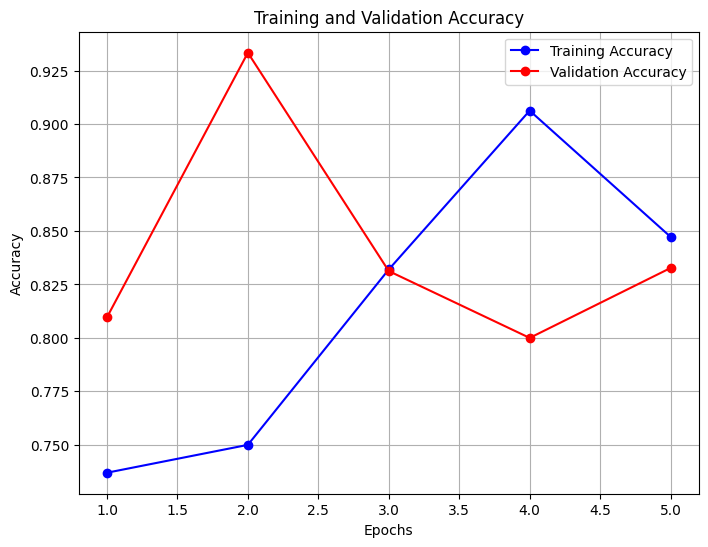

In [18]:
# Extract accuracy data
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


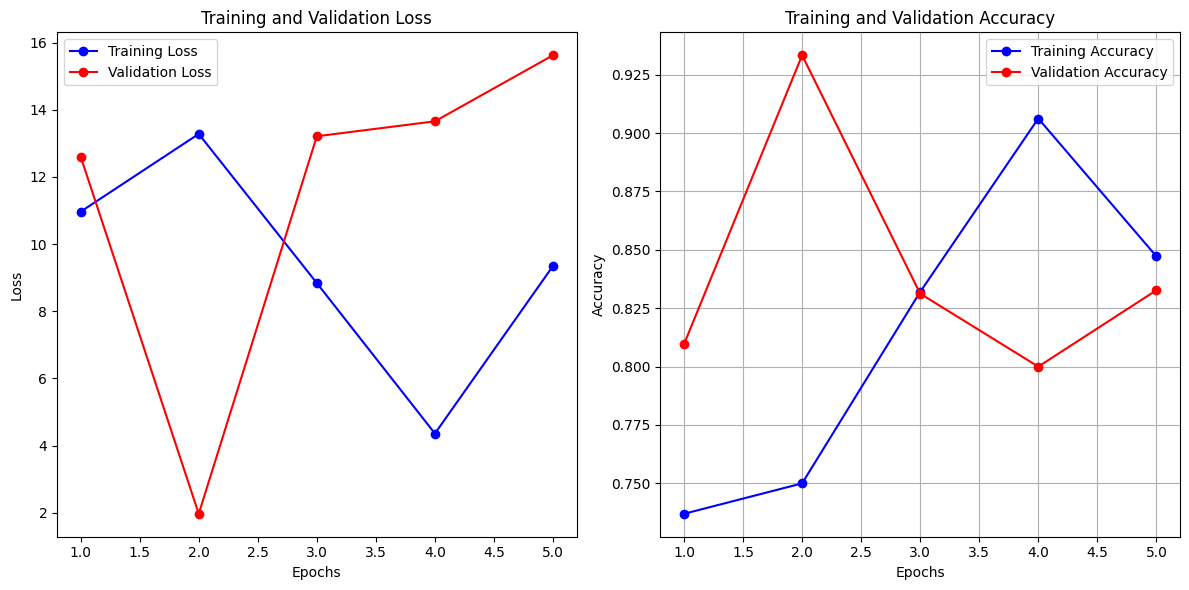

In [19]:
plt.figure(figsize=(12, 6))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.grid()
plt.show()


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerators
datagen = ImageDataGenerator(rescale=1./255)

# Train data generator
train_generator = datagen.flow_from_directory(
   os.path.join(unzip_dir, 'cnn/train'),  # Replace with your train dataset path
    target_size=(416,416),
    batch_size=32,
    class_mode='categorical'
)

# Validation data generator
validation_generator = datagen.flow_from_directory(
    os.path.join(unzip_dir, 'cnn/valid'),  # Replace with your validation dataset path
    target_size=(416,416),
    batch_size=32,
    class_mode='categorical'
)

# (Optional) Test data generator if you have a test folder
test_generator = datagen.flow_from_directory(
    os.path.join(unzip_dir, 'cnn/test'),  # Replace with your test dataset path
    target_size=(416,416),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 7324 images belonging to 6 classes.
Found 2095 images belonging to 6 classes.
Found 1045 images belonging to 6 classes.


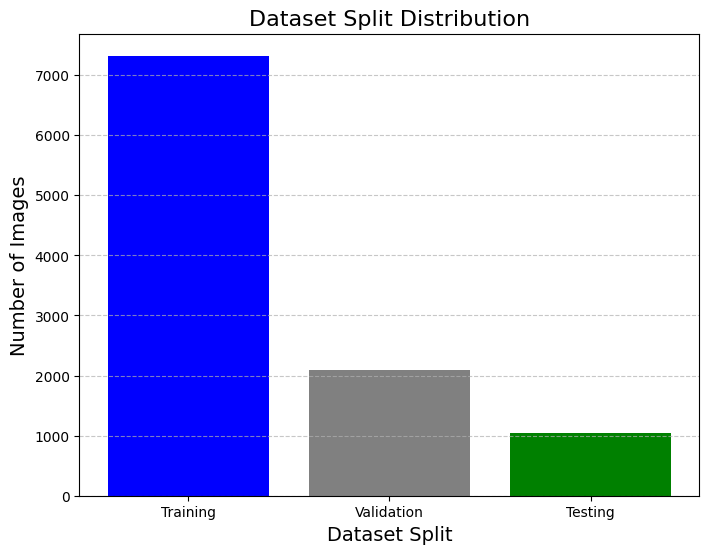

In [24]:
# Adjust counts based on the generators
splits = ['Training', 'Validation', 'Testing']
counts = [
    train_generator.samples,
    validation_generator.samples,
    test_generator.samples if 'test_generator' in locals() else 0  # Handle missing test generator
]

# Plot distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(splits, counts, color=['blue', 'grey', 'green'])
plt.title("Dataset Split Distribution", fontsize=16)
plt.xlabel("Dataset Split", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [31]:
import numpy as np

# Predict the classes for the test set
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)  # Convert predictions to class indices


 1/66 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 34s 520ms/step


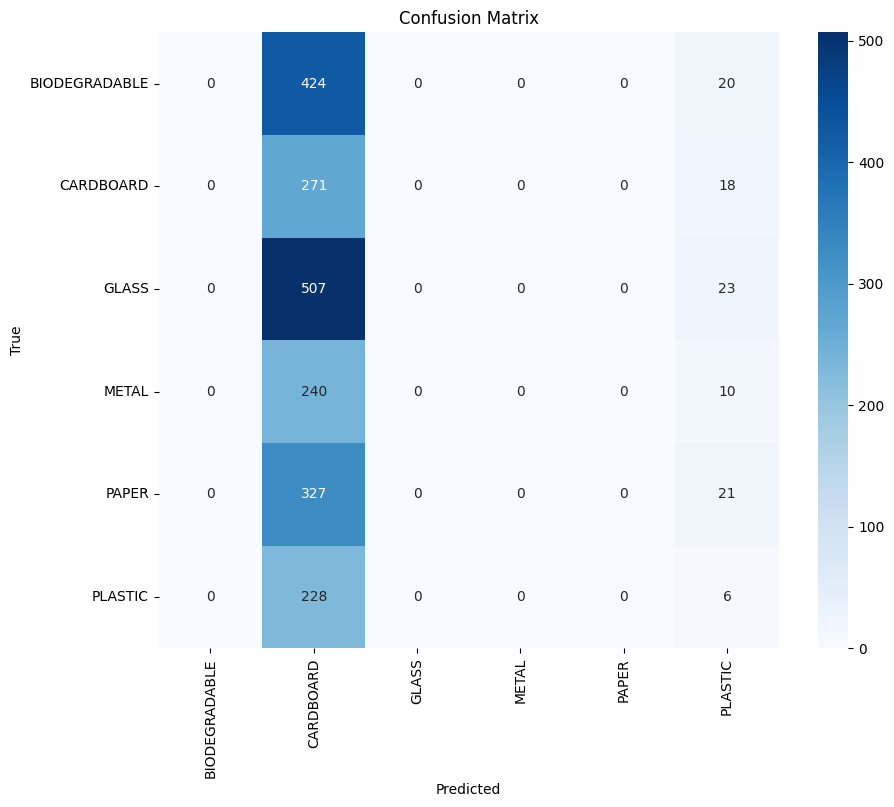

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get the true labels
y_true = validation_generator.classes  # True labels from the test generator

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [27]:
def plotImage(img_arr, labels, class_names):
    """
    Displays a few images with their corresponding labels.

    Parameters:
        img_arr: numpy array of images (e.g., from train_generator or test_generator).
        labels: numpy array of labels corresponding to the images.
        class_names: list of class names (e.g., test_generator.class_indices.keys()).
    """
    for im, label in zip(img_arr, labels):
        plt.figure(figsize=(5, 5))
        plt.imshow(im)
        plt.title(f"Class: {class_names[np.argmax(label)]}" if len(label) > 1 else f"Class: {class_names[label]}")
        plt.axis('off')
        plt.show()


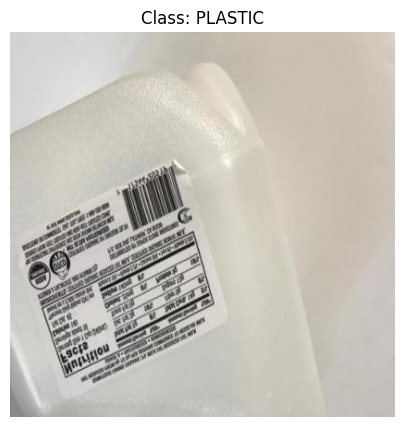

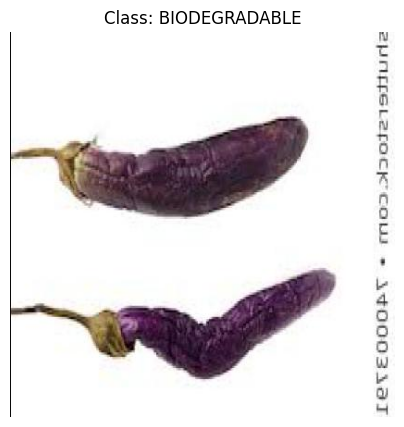

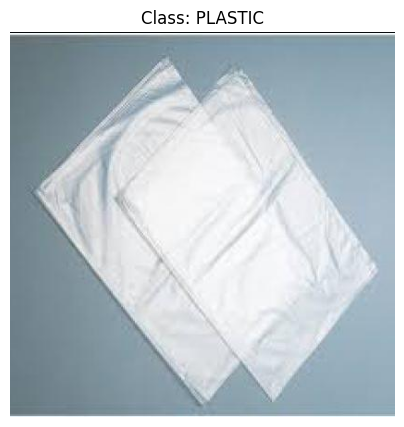

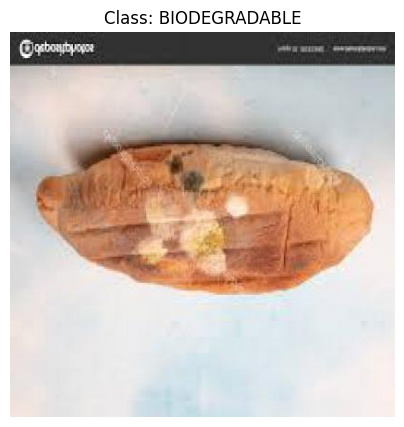

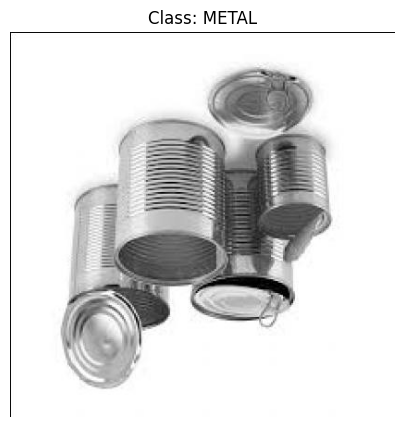

In [28]:
# Get a batch of training images and labels
images, labels = next(train_generator)  # Get the next batch
class_names = list(train_generator.class_indices.keys())  # Class names

# Plot the images with their labels
plotImage(images[:5], labels[:5], class_names)  # Display 5 images


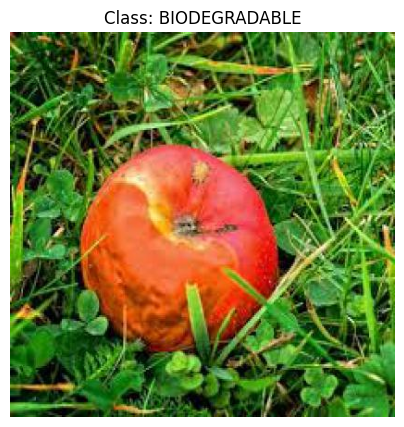

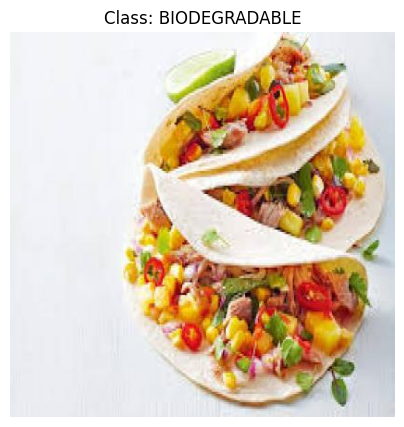

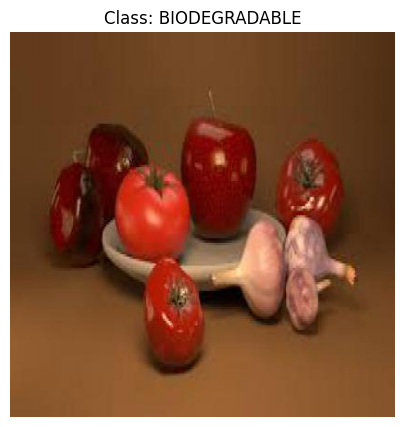

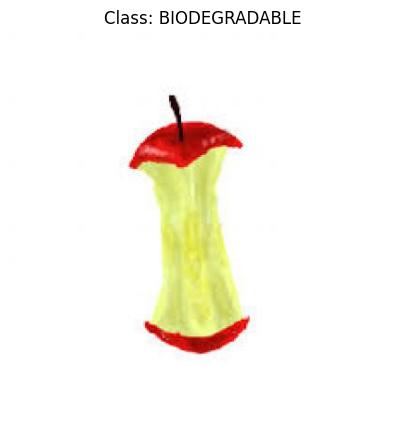

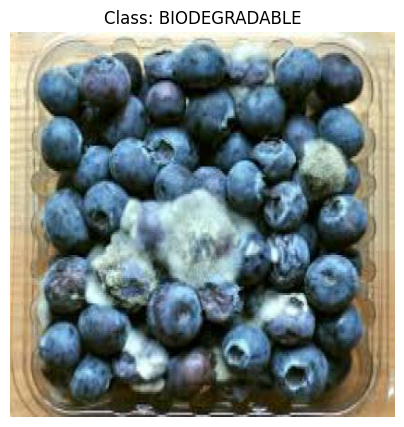

In [29]:
# Get a batch of test images and labels
images, labels = next(test_generator)  # Get the next batch
class_names = list(test_generator.class_indices.keys())  # Class names

# Plot the images with their labels
plotImage(images[:5], labels[:5], class_names)  # Display 5 images


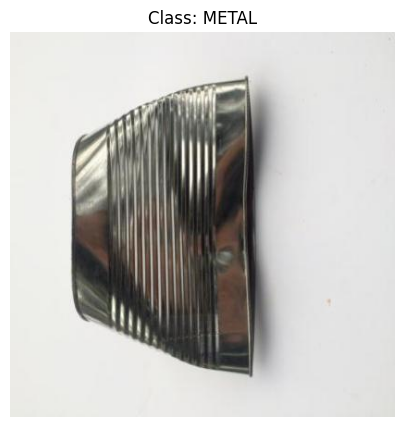

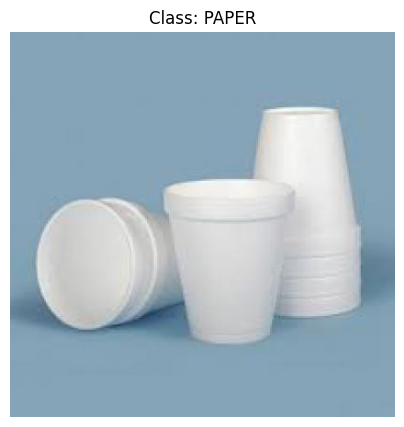

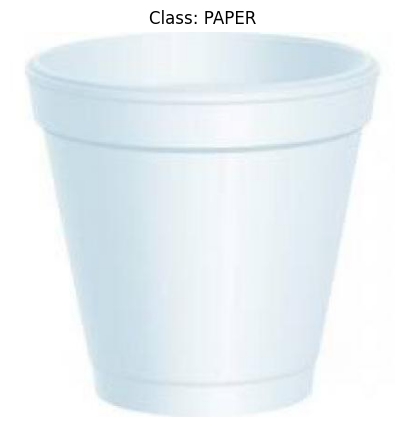

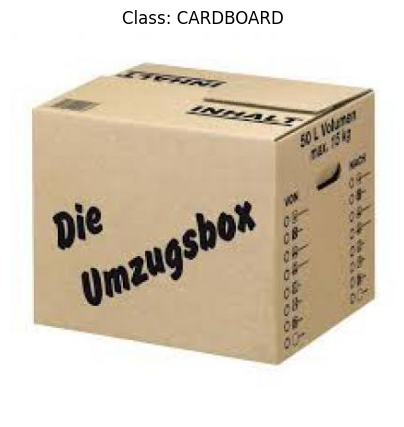

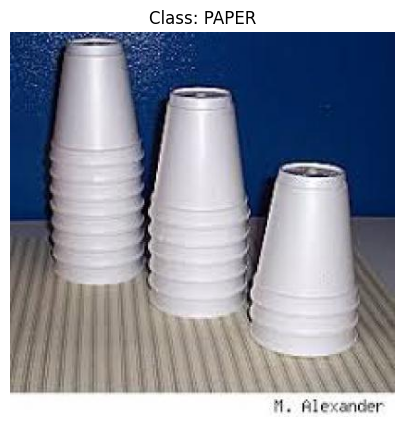

In [30]:
# Get a batch of test images and labels
images, labels = next(validation_generator)  # Get the next batch
class_names = list(validation_generator.class_indices.keys())  # Class names

# Plot the images with their labels
plotImage(images[:5], labels[:5], class_names)  # Display 5 images




**new model without early stoping**



In [33]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define ModelCheckpoint callback
mc = ModelCheckpoint(filepath='best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[mc]  # Only the ModelCheckpoint callback
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.5704 - loss: 3.0763
Epoch 1: val_accuracy improved from -inf to 0.69471, saving model to best_model.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 161s 697ms/step - accuracy: 0.5708 - loss: 3.0705 - val_accuracy: 0.6947 - val_loss: 46.7524
Epoch 2/10
  1/228 ━━━━━━━━━━━━━━━━━━━━ 1:57 518ms/step - accuracy: 0.7188 - loss: 0.8038

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.69471
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7188 - loss: 0.8038 - val_accuracy: 0.5333 - val_loss: 95.4022
Epoch 3/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.8016 - loss: 0.7150
Epoch 3: val_accuracy did not improve from 0.69471
228/228 ━━━━━━━━━━━━━━━━━━━━ 195s 694ms/step - accuracy: 0.8016 - loss: 0.7150 - val_accuracy: 0.6784 - val_loss: 57.3016
Epoch 4/10
  1/228 ━━━━━━━━━━━━━━━━━━━━ 1:58 521ms/step - accuracy: 0.7812 - loss: 0.7423
Epoch 4: val_accuracy improved from 0.69471 to 0.86667, saving model to best_model.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.7812 - loss: 0.7423 - val_accuracy: 0.8667 - val_loss: 10.1089
Epoch 5/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.8806 - loss: 0.3651
Epoch 5: val_accuracy did not improve from 0.86667
228/228 ━━━━━━━━━━━━━━━━━━━━ 158s 688ms/step - accuracy: 0.8807 - loss: 0.3650 - val_accuracy: 0.6928 - val_loss: 50.5753
Epoch 6/1

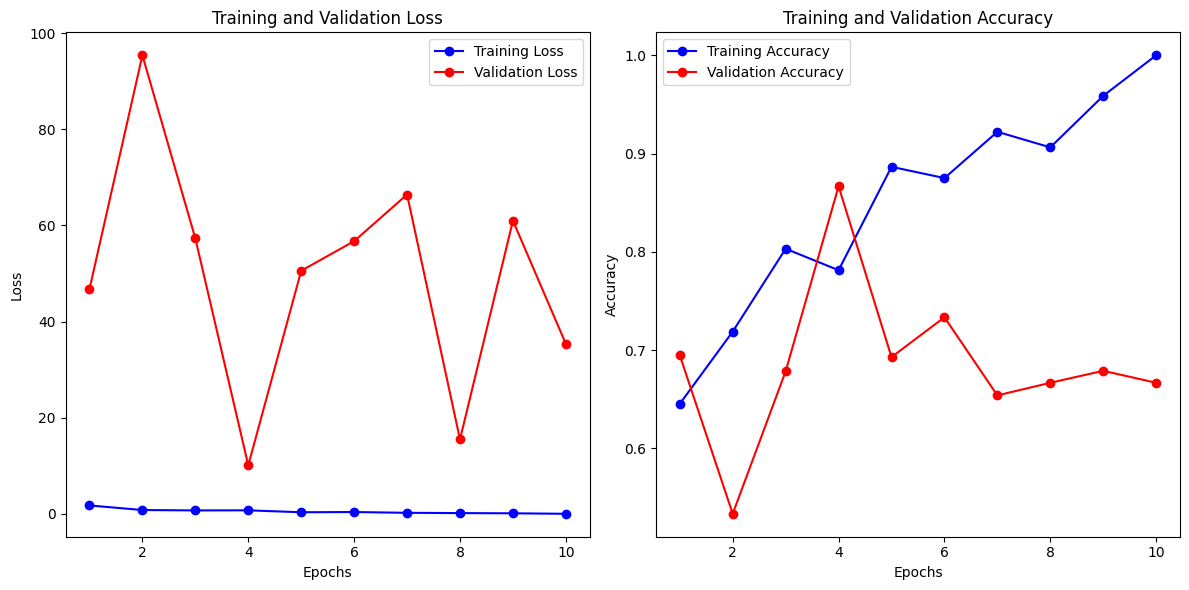

In [34]:
# Extract history data
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerators
datagen = ImageDataGenerator(rescale=1./255)

# Train data generator
train_generator = datagen.flow_from_directory(
   os.path.join(unzip_dir, 'cnn/train'),  # Replace with your train dataset path
    target_size=(416,416),
    batch_size=32,
    class_mode='categorical'
)

# Validation data generator
validation_generator = datagen.flow_from_directory(
    os.path.join(unzip_dir, 'cnn/valid'),  # Replace with your validation dataset path
    target_size=(416,416),
    batch_size=32,
    class_mode='categorical'
)

# (Optional) Test data generator if you have a test folder
test_generator = datagen.flow_from_directory(
    os.path.join(unzip_dir, 'cnn/test'),  # Replace with your test dataset path
    target_size=(416,416),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 7324 images belonging to 6 classes.
Found 2095 images belonging to 6 classes.
Found 1045 images belonging to 6 classes.


In [36]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 570ms/step - accuracy: 0.8625 - loss: 0.6487
Test Accuracy: 79.71%


In [37]:
import numpy as np

# Predict the classes for the test set
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)  # Convert predictions to class indices


66/66 ━━━━━━━━━━━━━━━━━━━━ 36s 532ms/step


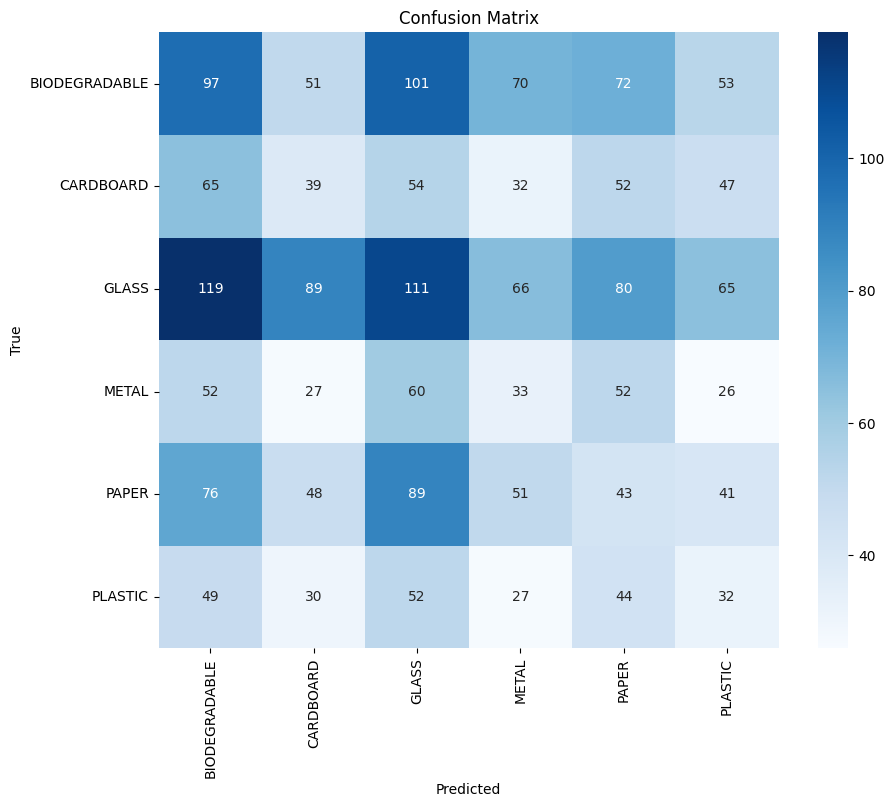

In [38]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get the true labels
y_true = validation_generator.classes  # True labels from the test generator

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


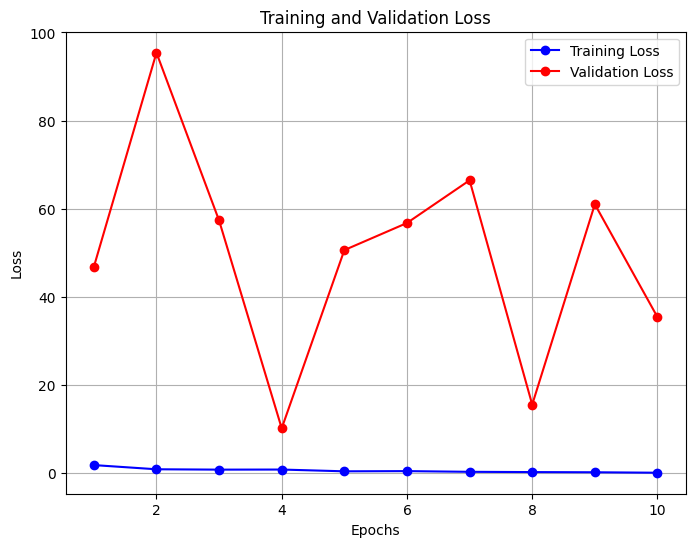

In [39]:
import matplotlib.pyplot as plt

# Extract data from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


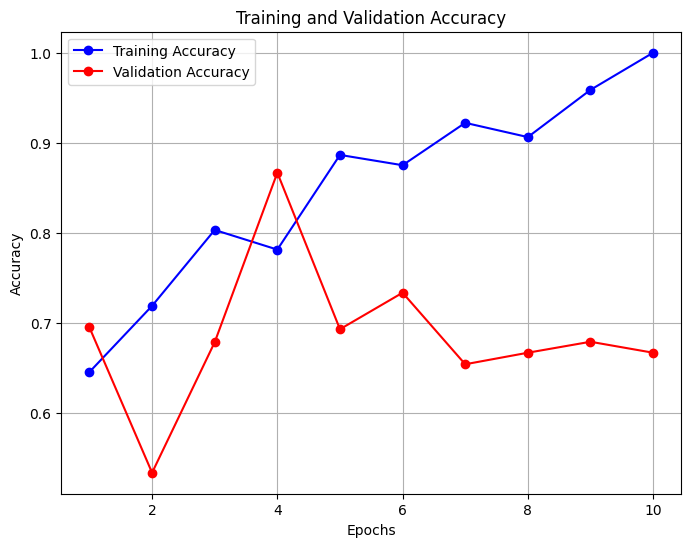

In [40]:
# Extract accuracy data
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


In [43]:
# Save the model to a file
model.save('best_model.keras')  # Adjust the filename if needed


In [ ]:
import numpy as np

# Predict the classes for the test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)  # Convert predictions to class indices


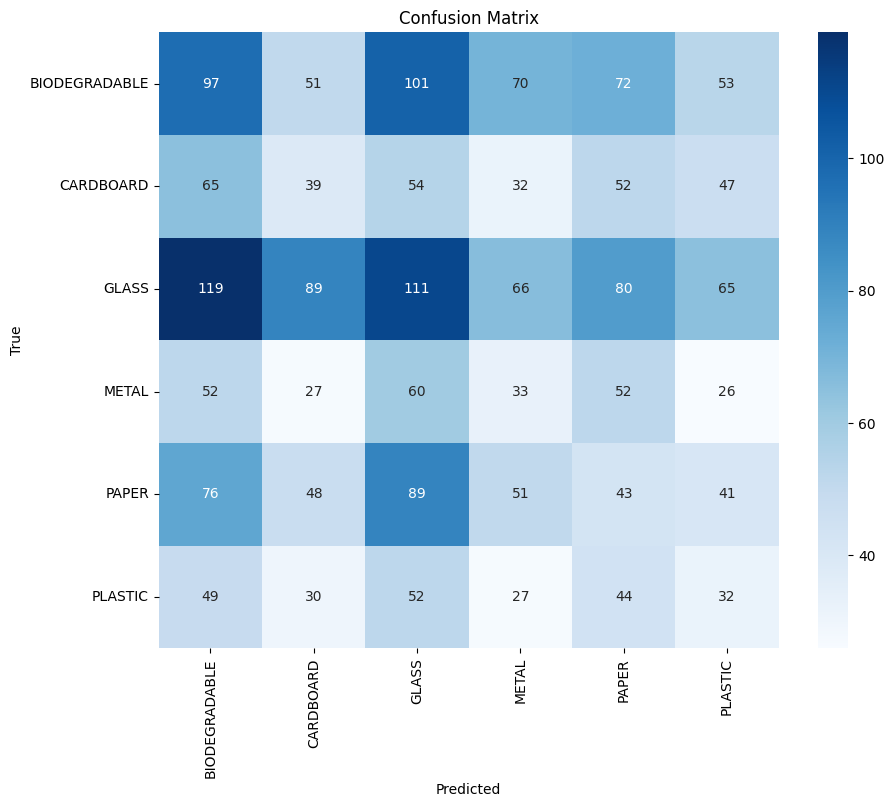

In [42]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get the true labels
y_true = validation_generator.classes  # True labels from the test generator

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
